## Regularized Linear Models
For a linear model, regularization is typically achieved by constraining the weights of the model.

### Ridge Regression
The main idea behind Ridge Regression is to find a New Line that does not fit the training data. In orther words, we introduce a small amount of Bias into how the new line is fit to the data, but in return for that samll amount of Bias, we get a significant drop in variance. By starting with a slightly worse fit, Ridge Regression can provide better long term predictions.

Ridge Regression is just a regularized version of Linear Regression.
A regularization term equal to $\alpha \sum_{i=1}^n \theta_i^2$ is added the cost function. This forces the algorith to not only fit the data but also keep the model weights as samll as possible. The hyperparameter $\alpha$ controls how much we want to regularizse the model. If $\alpha=0$, the Riege Regression is just Linear Regression. IF $\alpha$ is very large, then all weights end up very close to zero and the result is flat line going through the data's mean.

<i>Ridge Regression cost function:</i>
$$J(\theta) = MSE(\theta) + \frac{\alpha}{2} \sum_{i=1}^n \theta_i^2$$

Note: bias term $\theta_0$ is not regularized.

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form equation or by performing Gradient Descent.

<i> Ridge Regression closed form Solution</i>:

$$\hat{\theta} = (X^TX + \alpha A)^{-1} X^T y$$
This equation uses a matrix factorization technique by Cholesky.

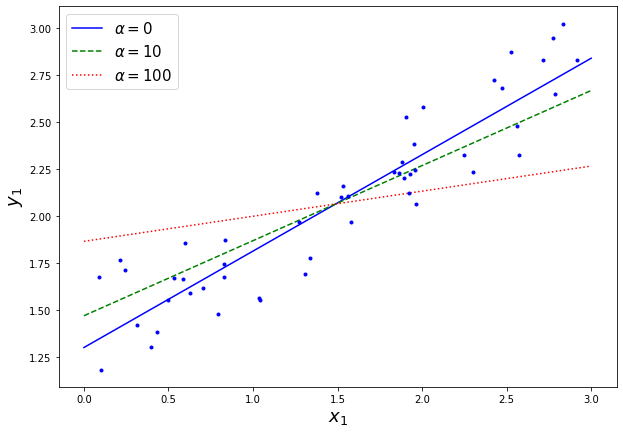

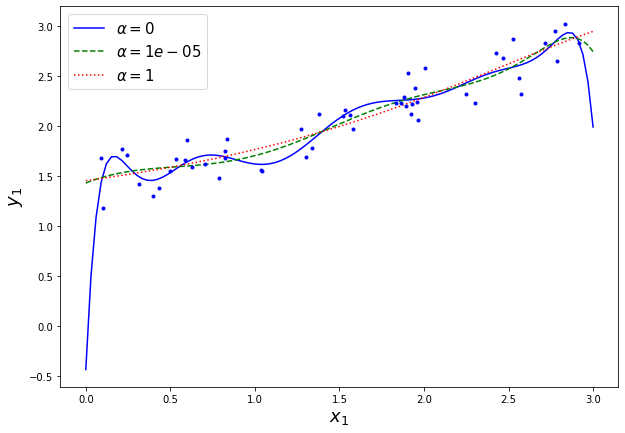

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Generate data
m = 50
X = 3*np.random.rand(m, 1)
y = 1 + 0.5*X + np.random.rand(m, 1)/1.5
X_new = np.linspace(0,3,100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    fig, ax = plt.subplots(figsize=(10, 7))
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha>0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
              ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        ax.plot(X_new, y_new_regul, style, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    ax.legend(loc="upper left", fontsize=15)
    ax.set_xlabel("$x_1$", fontsize=18)
    ax.set_ylabel("$y_1$", fontsize=18)

plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)        

### Lasso Regression
"Least Absolute Shrinkage and Selection Operator Regression"

Just like Ridge Regression, it adds a regularization term to the cost function, but it uses the $ℓ_1$ norm of the weight vector instead of half the square of the $ℓ_2$ norm.

<i>Lasso Regression cost function</i>
$$J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^n |\theta_i|$$

An important characteristic of Lasso Regression is that it tends to eliminate the
weights of the least important features:

C:\Users\shres\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5005998111283568, tolerance: 0.00108211014831302
  model = cd_fast.enet_coordinate_descent(


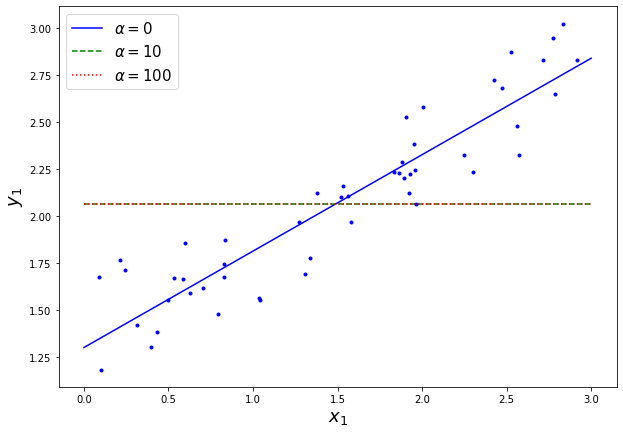

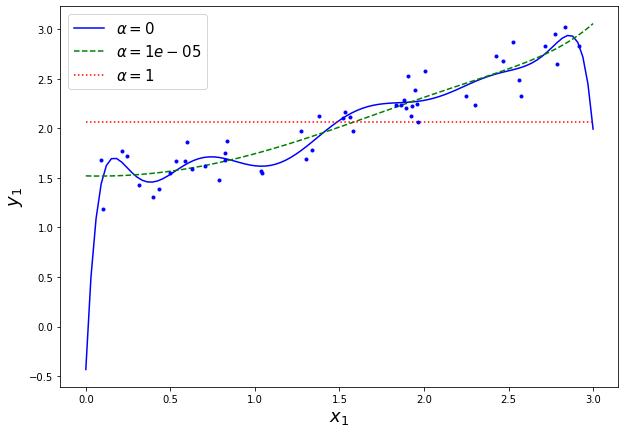

In [30]:
from sklearn.linear_model import Lasso

plot_model(Lasso, polynomial=False, alphas=(0, 10, 100), random_state=42)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)  

### Early Stopping
A very different way to regularize iterative learning algorithms such as Gradient
Descent is to stop training as soon as the validation error reaches a minimum. This is
called early stopping.

Best Epoch:  201
Best RMSE:  1.180018184235255


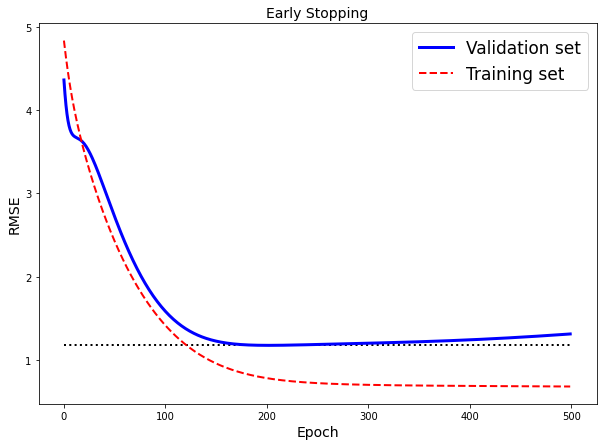

In [51]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], 
                                                  y[:50].ravel(), 
                                                  test_size=0.5, 
                                                  random_state=10)

# scale the data and transform it with PolynomialFeatues
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# define model
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

# Training the model
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    
# best rmse values and best_epoch
best_epoch = np.argmin(val_errors)
print('Best Epoch: ', best_epoch)
best_val_rmse = np.sqrt(val_errors[best_epoch])
print('Best RMSE: ', best_val_rmse)

# Plotting RMSE over epochs
fig, ax = plt.subplots(figsize=(10,7))
_ = ax.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)

_ = ax.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
_ = ax.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
_ = ax.set_xlabel("Epoch", fontsize=14)
_ = ax.set_ylabel("RMSE", fontsize=14)
_ = ax.set_title("Early Stopping", fontsize=14)
_ = ax.legend(loc="upper right", fontsize=17)
